In [1]:
# note Grakel does not seem to support Python >=3.10, Python 3.9 works fine
# you are free to remove imports that are not useful for you
from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA # to check your own implementation
from sklearn.manifold import TSNE
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math

In [2]:
# Some datasets, more datasets here https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets

"""
    The MUTAG dataset consists of 188 chemical compounds divided into two 
    classes according to their mutagenic effect on a bacterium. 

    The chemical data was obtained form http://cdb.ics.uci.edu and converted 
    to graphs, where vertices represent atoms and edges represent chemical 
    bonds. Explicit hydrogen atoms have been removed and vertices are labeled
    by atom type and edges by bond type (single, double, triple or aromatic).
    Chemical data was processed using the Chemistry Development Kit (v1.4).
"""

"""
    ENZYMES is a dataset of protein tertiary structures obtained from (Borgwardt et al., 2005) 
    consisting of 600 enzymes from the BRENDA enzyme database (Schomburg et al., 2004). 
    In this case the task is to correctly assign each enzyme to one of the 6 EC top-level 
    classes. 
"""

"""
    NCI1 and NCI109 represent two balanced subsets of datasets of chemical compounds screened 
    for activity against non-small cell lung cancer and ovarian cancer cell lines respectively
    (Wale and Karypis (2006) and http://pubchem.ncbi.nlm.nih.gov).
"""

dataset = fetch_dataset("MUTAG", verbose=False) # just replace by the name of the datasets you want "ENZYMES", "NCI1"
G = dataset.data
y = dataset.target

In [3]:
from __future__ import print_function
from grakel.utils import cross_validate_Kfold_SVM
# Generates a list of kernel matrices using the Weisfeiler-Lehman subtree kernel
# Each kernel matrix is generated by setting the number of iterations of the
# kernel to a different value (from 2 to 7)
Ks = list()
for i in range(1, 7):
    
    gk = WeisfeilerLehman(n_iter=i, base_graph_kernel=VertexHistogram, normalize=True)
    K = gk.fit_transform(G)
    Ks.append(K)
print(gk)

WeisfeilerLehman(n_iter=6, normalize=True)


In [4]:
# Performs 10-fold cross-validation over different kernels and the parameter C of
# SVM and repeats the experiment 10 times with different folds
accs = cross_validate_Kfold_SVM([Ks], y, n_iter=10)
print("Average accuracy:", str(round(np.mean(accs[0])*100, 2)) + "%")
print("Standard deviation:", str(round(np.std(accs[0])*100, 2)) + "%")

Average accuracy: 82.82%
Standard deviation: 1.92%


In [5]:
K.shape

(188, 188)

In [17]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import cmath

def decompose(K):
    K_matrix = K
#     eigval, eigvec = eigen_val_vec(K_matrix)
    eigval, eigvec = np.linalg.eig(K_matrix)
    if not is_pos_semidef(eigval):
        warnings.warn("The kernel matrix is not positive semi definitive!")
    # Normalize eigenvectors and compute singular values of K
    tuple_eig = [(np.sqrt(eigval[i]), eigvec[:,i] / cmath.sqrt(eigval[i])) for i in range(len(eigval))]
    tuple_eig.sort(key=lambda x: x[0], reverse=True)
    return tuple_eig

def is_pos_semidef(x):
    return np.all(x >= 0)  # if all the eigen values >= 0, then it's positive semi definitive

def eigen_val_vec(matrix):
    results = sp.Matrix(matrix).eigenvects()
    eigval, eigvec = [], []

    for result in results:
        for _ in range(result[1]):
            eigval.append(result[0])
            eigvec.append(result[2][_].values())

    eigval, eigvec = np.array(eigval, dtype='float64'), np.array(eigvec, dtype='float64').T

    return eigval, eigvec

In [18]:
K_matrix = K
one_mat = np.ones(K_matrix.shape) / K_matrix.shape[1]
K_tilde = K_matrix - one_mat @ K_matrix - K_matrix @ one_mat + one_mat @ K_matrix @ one_mat
tuple_eig = decompose(K_tilde)

/Users/maurice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: The kernel matrix is not positive semi definitive!
  


In [19]:
tuple_eig

[((3.118560822091953+0j),
  array([-2.29786503e-02+0.j,  6.45441974e-03+0.j,  6.18344298e-03+0.j,
         -2.96277501e-02+0.j,  2.13452902e-02+0.j,  1.53074208e-02+0.j,
         -1.74858691e-02+0.j, -1.07292366e-02+0.j,  3.36512703e-02+0.j,
         -1.75093365e-02+0.j, -2.44981980e-02+0.j, -2.56418109e-02+0.j,
         -1.01614507e-02+0.j,  2.09626042e-02+0.j, -3.27209005e-02+0.j,
         -1.06771549e-02+0.j,  2.82415004e-02+0.j, -1.26321151e-02+0.j,
          1.13941514e-02+0.j, -1.58126732e-02+0.j,  1.03479419e-02+0.j,
         -1.34600492e-02+0.j, -3.26572089e-02+0.j, -3.41231003e-02+0.j,
         -1.18877177e-02+0.j,  4.54315147e-02+0.j, -3.53975162e-02+0.j,
         -1.28712254e-02+0.j,  2.42854589e-02+0.j, -3.01893848e-02+0.j,
         -1.16980726e-02+0.j,  3.84448694e-02+0.j, -6.84405273e-03+0.j,
         -1.08570254e-02+0.j, -1.01004913e-02+0.j, -1.50009855e-02+0.j,
         -1.30879419e-02+0.j, -1.10866695e-02+0.j,  1.08946066e-02+0.j,
         -1.44050619e-02+0.j, -1.33863

In [20]:
aaa

In [21]:
scores = projection(tuple_eig, 2)

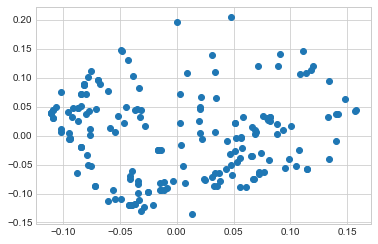

In [23]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
plt.scatter(scores[0, :], scores[1, :])
plt.show()

In [26]:
s = 0
for g in G:
    s += len(g[2])
print(s)

7442


In [27]:
g[2]

{(3357, 3356): 1,
 (3356, 3357): 1,
 (3358, 3357): 1,
 (3357, 3358): 1,
 (3359, 3358): 1,
 (3358, 3359): 1,
 (3360, 3359): 2,
 (3359, 3360): 2,
 (3361, 3360): 1,
 (3360, 3361): 1,
 (3362, 3361): 2,
 (3361, 3362): 2,
 (3363, 3362): 1,
 (3362, 3363): 1,
 (3364, 3363): 2,
 (3363, 3364): 2,
 (3365, 3364): 1,
 (3364, 3365): 1,
 (3366, 3365): 2,
 (3365, 3366): 2,
 (3366, 3361): 1,
 (3361, 3366): 1,
 (3367, 3366): 2,
 (3366, 3367): 2,
 (3367, 3359): 1,
 (3359, 3367): 1,
 (3368, 3367): 1,
 (3367, 3368): 1,
 (3368, 3356): 1,
 (3356, 3368): 1,
 (3369, 3364): 1,
 (3364, 3369): 1,
 (3370, 3369): 2,
 (3369, 3370): 2,
 (3371, 3369): 1,
 (3369, 3371): 1}